# **Bluebikes Ride Sharing Analysis Before and During Pandemic**

## **Table of Contents**
1. Introduction
2. Business Questions
3. Data Collection
4. Data Wragling
5. Exploratory Data Analysis and Data Visualization
6. Conclusions


## **1. Introduction**

Bluebikes is a bike sharing system that operates in the Boston Metro Area and surrounding communities. It consists of a fleet of bikes that are distributed in the city across a network of docking stations. Users can unlock bikes from one station and return them at any other station which makes the service useful for one-way trips.

The service started operating in Boston in 2011 under the name "Hubway" and transitioned to "Bluebikes" in 2018 when Blue Cross Blue Shield of Massachusetts became its sponsor. The bike sharing system has succesfully grown its operation and has become a vital commuting method for many Boston residents which rely on it to move around the city without dealing with the hassle of owning a vehicle in highly populated areas.

The purpose of the present analysis is to perform exploratory data analysis to understand at a broad scale the program's operation, how the pandemic has affected it and identify possible service gaps within the allocation of bikes across docking stations.

## **2. Business Questions**

Before diving into the data it is important to define what is it that we want to learn from it. By doing so, it will become easier to set the scope of the analysis and stay true to it. In that sense, I will pretend to be a recently hired data analyst at Motivate, Co trying to develop a basic understanding of the company's operation is Boston.

Moreover, the following questions come to mind:
1. Most used routes
2. How do holidays influence bike sharing?
3. How does weather influence bike sharing?
4. How has the pandemic changed bike sharing patterns?

## **3. Data Collection**

To answer the questions above, three datasets from the following sources were used:
* Bluebikes Trip History Data [(url)](https://www.bluebikes.com/system-data)
* US Holiday Data [(url)](https://www.timeanddate.com/holidays/us/)
* Boston Historic Weather Data (NOAA Database) [(url)](https://www.ncdc.noaa.gov/cdo-web/search)

In [1]:
# Import Packages:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import seaborn as sns; sns.set(style='darkgrid')

In [6]:
# Load Blue Bikes Trip History Data:

df = pd.read_csv('trip_history.csv')

# Load US Holiday Data:

US_holidays = pd.read_csv('US Holidays.csv')

# Boston Historic Weather Data:

weather = pd.read_csv('Daily Weather Data.csv')


/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# Check dataframe shapes:
print(df.shape)
print(US_holidays.shape)
print(weather.shape)

(4596219, 16)
(22, 2)
(731, 9)


## **4. Data Wrangling**

### **4.1 Blue Bikes Trip History Data**

In [4]:
# Check Datatypes:    
df.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
postal code                 object
birth year                 float64
gender                     float64
dtype: object

In [5]:
# Convert starttime and stoptime to datetime type:
df['starttime'] =  pd.to_datetime(df['starttime'], format='%Y-%m-%d')
df['stoptime'] =  pd.to_datetime(df['stoptime'], format='%Y-%m-%d')

In [6]:
# Function to extract year of the ride:
def year_extract(date_time):
    return date_time.year

df['startyear']= df['starttime'].apply(year_extract)
df['endyear']= df['stoptime'].apply(year_extract)

# Function to extract month of the ride:
def month_extract(date_time):
    return calendar.month_name[date_time.month]

df['startmonth']= df['starttime'].apply(month_extract)
df['endmonth']= df['stoptime'].apply(month_extract)

# Function to extract day of the month in which the ride occurred:
def month_day_extract(date_time):
    return date_time.day

df['startmonthday']= df['starttime'].apply(month_day_extract)
df['endmonthday']= df['stoptime'].apply(month_day_extract)

# Function to extract week day in which the ride occurred:
def week_day_extract(date_time):
    return calendar.day_name[date_time.weekday()]

df['startday']= df['starttime'].apply(week_day_extract)
df['endday']= df['stoptime'].apply(week_day_extract)

# Function to extract hour of the day in which the ride occurred:
def hour_extract(date_time):
    return date_time.hour

df['start_hour']= df['starttime'].apply(hour_extract)
df['end_hour']= df['stoptime'].apply(hour_extract)

In [7]:
# Create Riding Routes:
df['Route'] = df['start station name'] + '--->' + df['end station name']

df['Ride_id'] = df.index + 1
df['Ride_id'] = df['Ride_id'].astype(object)

### **4.2 US Holiday Data**

In [8]:
# Check Datatypes:    
US_holidays.dtypes

Date       object
Holiday    object
dtype: object

In [9]:
# Convert 'Date' feature to datetime type:
US_holidays['Date'] =  pd.to_datetime(US_holidays['Date'], format='%m/%d/%y')

### **4.3 Boston Historic Weather Data**

In [10]:
# Check Datatypes:
weather.dtypes

STATION     object
NAME        object
DATE        object
AWND       float64
PRCP       float64
SNOW       float64
TAVG         int64
TMAX         int64
TMIN         int64
dtype: object

In [11]:
# Subset data of interest:
weather = weather.iloc[:, 2:]

# Rename remaining features:
weather.rename(columns = {'DATE': 'date_text', 'AWND': 'wind_speed',
                          'PRCP' : 'precipitation', 'SNOW' : 'snowfall',
                          'TAVG' : 'average_temp', 'TMAX' : 'max_temp',
                          'TMIN' : 'min_temp'}, inplace = True)

# Convert the 'date_text' feature to datetime type:
weather.date_text = pd.to_datetime(weather['date_text'], format='%Y-%m-%d')

### **4.4 Merging Dataframes**

In [12]:
# Create common field among dataframes that can be used as key for merging them:

# Funtion to extract date of the ride:
def date_extract(date_time):
    return date_time.date()

df['date_text'] = df['starttime'].apply(date_extract)
US_holidays['date_text']= US_holidays['Date'].apply(date_extract)
weather['date_text']= weather['date_text'].apply(date_extract)

In [13]:
# Merge US holidays to Trip History dataframe using the 'date_text' key:
df = pd.merge(left = df, right = US_holidays, on='date_text', how='left')

In [14]:
#Merge weather data into main dataframe using the 'date_text' key:
df = pd.merge(left = df, right = weather, on = 'date_text', how = 'left')

In [15]:
# Check resulting datatypes:
df.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
postal code                        object
birth year                        float64
gender                            float64
startyear                           int64
endyear                             int64
startmonth                         object
endmonth                           object
startmonthday                       int64
endmonthday                         int64
startday                           object
endday                            

In [16]:
# Modify data types:
df['start station id'] = df['start station id'].astype(object)
df['end station id'] = df['end station id'].astype(object)
df['bikeid'] = df['bikeid'].astype(object)
df['gender'] = df['gender'].astype(object)
df['startyear'] = df['startyear'].astype(object)
df['endyear'] = df['endyear'].astype(object)
df['startmonthday'] = df['startmonthday'].astype(object)
df['endmonthday'] = df['endmonthday'].astype(object)
df['start_hour'] = df['start_hour'].astype(object)
df['end_hour'] = df['end_hour'].astype(object)

In [17]:
# Check presence of null values:
df.isnull().sum()

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
postal code                3082973
birth year                 1657472
gender                     1657472
startyear                        0
endyear                          0
startmonth                       0
endmonth                         0
startmonthday                    0
endmonthday                      0
startday                         0
endday                           0
start_hour                       0
end_hour                         0
Route                            0
Ride_id                          0
date_text           

In [18]:
# Check holiday feature null values:
df.Holiday.value_counts()

Independence Day              20913
Labor Day                     18737
Columbus Day                  16405
Veterans Day                  15509
Memorial Day                  12673
Presidents' Day                5077
Christmas Eve                  3619
Thanksgiving Day               2905
New Year's Day                 2841
Martin Luther King Jr. Day     2272
Christmas Day                  1188
Name: Holiday, dtype: int64

Null values simply represent the lack of a Holiday in the day of the ride. They will be replace with 'None'to indicate a Non-Holiday occurrence.

In [19]:
# Replace null values:
df['Holiday'].fillna('None', inplace=True)

# Check results:
df.Holiday.value_counts()

None                          4494080
Independence Day                20913
Labor Day                       18737
Columbus Day                    16405
Veterans Day                    15509
Memorial Day                    12673
Presidents' Day                  5077
Christmas Eve                    3619
Thanksgiving Day                 2905
New Year's Day                   2841
Martin Luther King Jr. Day       2272
Christmas Day                    1188
Name: Holiday, dtype: int64

In [20]:
# Create a binary column to signal Holiday and Non-Holiday rides:
df['Holiday Name'] = df['Holiday']

df['Holiday'] = df['Holiday'].str.replace('None','No')
df['Holiday'] = df['Holiday'].str.replace('Labor Day','Yes')
df['Holiday'] = df['Holiday'].str.replace('Memorial Day','Yes')
df['Holiday'] = df['Holiday'].str.replace('Independence Day','Yes')
df['Holiday'] = df['Holiday'].str.replace('Thanksgiving Day','Yes')
df['Holiday'] = df['Holiday'].str.replace('Christmas Eve','Yes')
df['Holiday'] = df['Holiday'].str.replace('Columbus Day','Yes')
df['Holiday'] = df['Holiday'].str.replace('Veterans Day','Yes')
df['Holiday'] = df['Holiday'].str.replace("New Year's Day",'Yes')
df['Holiday'] = df['Holiday'].str.replace('Christmas Day','Yes')
df['Holiday'] = df['Holiday'].str.replace("Presidents' Day",'Yes')
df['Holiday'] = df['Holiday'].str.replace('Martin Luther King Jr. Day','Yes')

df.Holiday.value_counts()

No     4494080
Yes     102139
Name: Holiday, dtype: int64

In [21]:
# Create 'timeline' feature to generate a marker that allows to diferentiate between pre-pandemic and pandemic rides:
max_date = datetime(2020, 3, 10) #Day when State of Emergency was declared in Boston, MA.

df['timeline'] = ''
df['timeline'] = np.where((df.starttime < max_date),'pre-pandemic',df.timeline)
df['timeline'] = np.where((df.starttime >= max_date),'pandemic',df.timeline)

df.timeline.value_counts()

pre-pandemic    2835885
pandemic        1760334
Name: timeline, dtype: int64

In [22]:
# Drop unnecesary columns:
df.drop(columns = ['Date', 'postal code', 'birth year', 'gender'], inplace = True)

In [23]:
# Check resulting null values:
df.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
startyear                  0
endyear                    0
startmonth                 0
endmonth                   0
startmonthday              0
endmonthday                0
startday                   0
endday                     0
start_hour                 0
end_hour                   0
Route                      0
Ride_id                    0
date_text                  0
Holiday                    0
wind_speed                 0
precipitation              0
snowfall                   0
average_temp               0
max_temp                   0
min_temp                   0
Holiday Name               0
timeline      

## **5. Exploratory Data Analysis and Data Visualization**

### **5.1 Univariate Analysis**

### **5.1.1 Numerical Features**

### Trip Duration (secs)

In [24]:
# Descriptive Statistics:
df.tripduration.describe()

count    4.596219e+06
mean     2.021882e+03
std      8.296502e+04
min      6.100000e+01
25%      4.410000e+02
50%      7.580000e+02
75%      1.296000e+03
max      4.256714e+07
Name: tripduration, dtype: float64

Minimum trip duration of 61 seconds, and maximum of 42,567,140 seconds (equivalent to 492.67 days) which could be
outliers caused by users that do not return their bikes on time, bikes left undocked, unsuccesful docking, etc.

Text(0, 0.5, 'frequency')

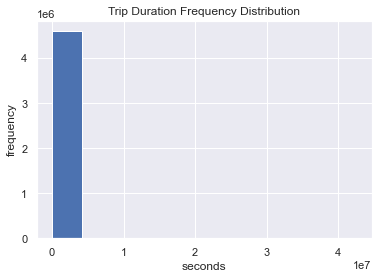

In [25]:
# Frequency Distribution:
plt.hist(df['tripduration'])
plt.title('Trip Duration Frequency Distribution')
plt.xlabel('seconds')
plt.ylabel('frequency')

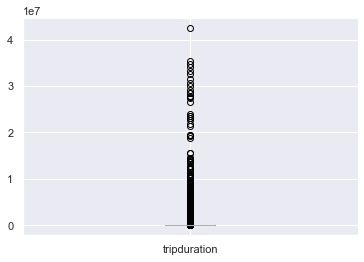

In [26]:
# Check presence of outliers:
df.boxplot(column = ['tripduration'])

In [27]:
# Check upper and lower bounds for outlier values:
Q1 = df.tripduration.quantile(0.25)
Q3 = df.tripduration.quantile(0.5)
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
print(lb)
ub = Q3 + 1.5 * IQR 
print(ub)

-34.5
1233.5


Any trip length superior to 1,233.5 seconds (equivalent to 20.55 minutes) is considered an outlier. This indicates that bikes are mostly being used for short trips.

In [28]:
# Check quantity of outliers:
cond = df[df['tripduration'] > 1233.5]
print(cond.shape)

(1241211, 35)


There are 1,241,211 outlier values (equivalent to 27% of the data). Having such a large presence of outlier values makes it impossible to discard them. Let's dig deeper into them:

In [29]:
# How many of those outlier rides are done by subscribers vs casual users?
cond.usertype.value_counts()

Subscriber    646091
Customer      595120
Name: usertype, dtype: int64

One could think that longer trips are taken by Casual Users who probably use the bikes for recreation purposes in more ocassions that Subscribers. However, the results above show that there is no clear sign of this pattern. 52% of the outlier ride lengths were performed by Subscribers and around 48% by Casual users.

I will proceed in first place to convert lenghts to minutes which is easier to interpret than seconds.

Text(0, 0.5, 'frequency')

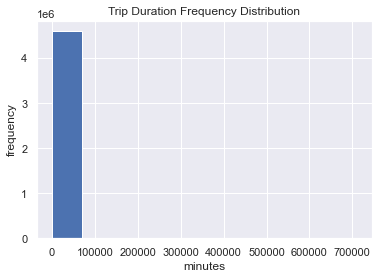

In [30]:
# Convert trip duration to minutes:
df.tripduration = df.tripduration/60

# Plot frequency again:
plt.hist(df['tripduration'])
plt.title('Trip Duration Frequency Distribution')
plt.xlabel('minutes')
plt.ylabel('frequency')

It is impossible to interpret the graph abover due to the presence of outliers, which skews the data to the right. I will proceed to discretize the feature by creating length buckets that are in accordance to Blue Bike's pricing plans maximum allowed trip duration without incurring in extra time fees:

* Single Trip Pass: up to 30 minutes of continuous ride time.
* Monthly and Annual Membership: up to 45 minutes of continuous ride time.
* Income-Eligible Program Membership: up to 60 minutes of continuous ride time.
* Adventure Pass: up to 2 hours of continuous ride time.

These binning categories were chosen because in general I believe that users will try to avoid paying more than what they initially signed up for.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

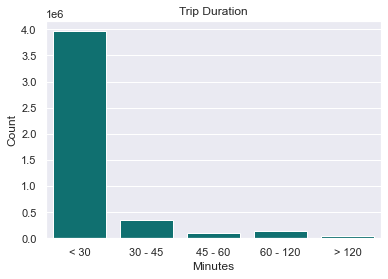

In [31]:
# Discretize trip duration:
df.tripduration= pd.cut(df.tripduration,bins=[0, 30, 45, 60, 120, 999999999999],
       labels=['< 30', '30 - 45', '45 - 60', '60 - 120', '> 120'])

# Visualize results:
sns.countplot(df['tripduration'], color = 'teal')
plt.title('Trip Duration')
plt.xlabel('Minutes')
plt.xticks(rotation=0)
plt.ylabel('Count')

It is possible to see that the vast majority of rides are under 30 minutes, which shows that the service is mainly used to perform short trips (probably for commuting around short stretches inside the city).

### Wind Speed (mph)

In [32]:
# Descriptive Statistics:
df.wind_speed.describe() 

count    4.596219e+06
mean     1.044060e+01
std      3.347714e+00
min      2.460000e+00
25%      8.050000e+00
50%      9.840000e+00
75%      1.208000e+01
max      2.550000e+01
Name: wind_speed, dtype: float64

It is possible to see that the Wind Speed in Boston when rides occurred ranges from 2.46 to 25.5 miles per hour.

Text(0, 0.5, 'frequency')

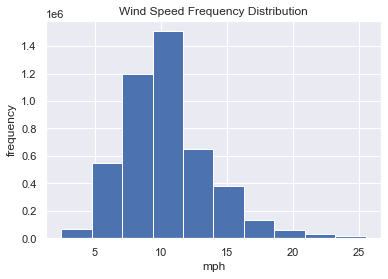

In [33]:
# Plot frequency distribution:
plt.hist(df['wind_speed'])
plt.title('Wind Speed Frequency Distribution')
plt.xlabel('mph')
plt.ylabel('frequency')

It is possible to see that the feature is close to a Normal distribution. It presents a slight skew to the right which shows that the majority of rides ocurred with a wind speed of less than 10 mph.

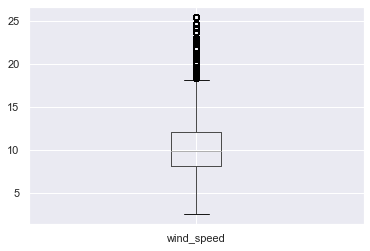

In [34]:
# Check presence of outliers:
df.boxplot(column = ['wind_speed']) 

It is possible to see that there are outliers on the right tail of the distribution. Despite that, Boston is one of the windiest cities in the US so I will leave outliers unaltered.

I will proceed to discretize the feature using Beaufort's Wind Scale so it is easier to interpret and use in the analysis:

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

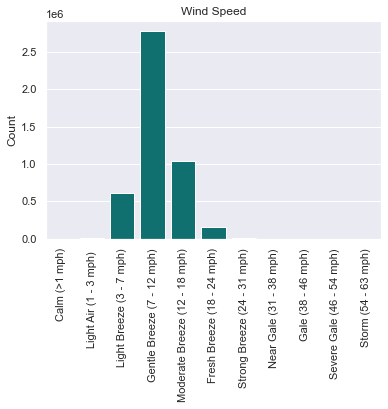

In [35]:
# Discretize wind speed using Beaufort's Wind Scale:
df.wind_speed = pd.cut(df.wind_speed,bins=[0,1,3,7,12,18,24,31,38,46,54,63],
       labels=['Calm (>1 mph)','Light Air (1 - 3 mph) ','Light Breeze (3 - 7 mph)',
               'Gentle Breeze (7 - 12 mph)','Moderate Breeze (12 - 18 mph)',
               'Fresh Breeze (18 - 24 mph)','Strong Breeze (24 - 31 mph)',
               'Near Gale (31 - 38 mph)','Gale (38 - 46 mph)',
               'Severe Gale (46 - 54 mph)', 'Storm (54 - 63 mph)'])

# Visualize results:
sns.countplot(df['wind_speed'], color = 'teal')
plt.title('Wind Speed')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Count')

We can see that most rides were made when the wind speed could be interpreted as a "Gentle Breeze" according to Beaufort's scale.

### Precipitation (inches)

In [36]:
# Descriptive statistics:
df.precipitation.describe()

count    4.596219e+06
mean     8.349818e-02
std      2.420703e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e-02
max      2.300000e+00
Name: precipitation, dtype: float64

Rides ocurred with precipitation ranging from 0 to 2.3 inches of rainfall.

Text(0, 0.5, 'frequency')

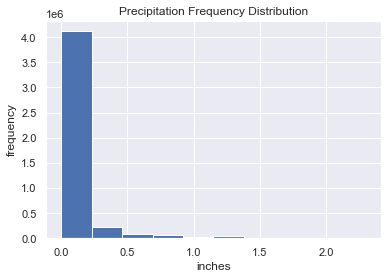

In [37]:
# Plot frequency distribution:
plt.hist(df['precipitation'])
plt.title('Precipitation Frequency Distribution')
plt.xlabel('inches')
plt.ylabel('frequency')

The distribution is skewed to the right. The majority of rides occurred when rainfall is closer to zero inches (no precipitation).

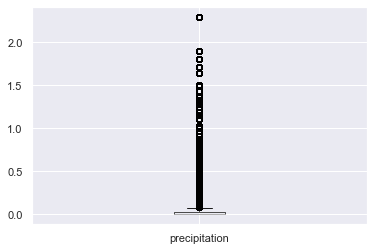

In [38]:
# Check presence of outliers:
df.boxplot(column = ['precipitation'])

There is a large quantity of outliers, however I will not attempt to modify them. They may be signaled as outliers because the majority of rides occurr when it is not raining. 

I will discretize the variable so it is easier to understand the impact of rain versus no rain over rides:

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

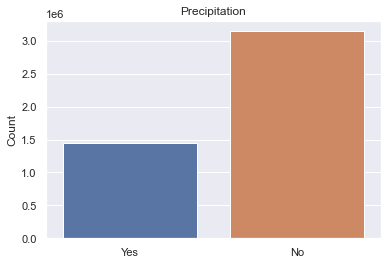

In [39]:
# Discretize the precipitation variable:
df['precipitation'] = np.where((df.precipitation == 0.00),'No',df.precipitation)
df['precipitation'] = np.where((df.precipitation != 'No'),'Yes',df.precipitation)

# Visualize results:
sns.countplot(df['precipitation'])
plt.title('Precipitation')
plt.xlabel('')
plt.ylabel('Count')

The amount of rides that occurred while there was no rainfall doubles the amount that happend while raining. Now, let's see the average number of rides of rainy versus non-rainy days.

Text(-0.16499999999999915, 0.5, 'Average number of Rides')

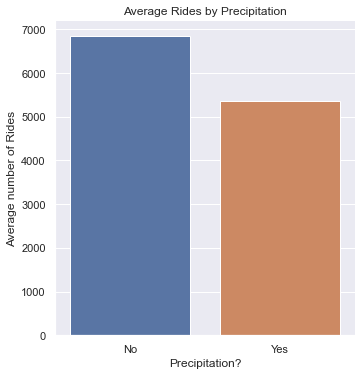

In [40]:
# Group data by Precipitation and Date to calculate the average amount of rides when there is rain or not:
mean_rides_precip = df.groupby(["precipitation", "date_text"]).size().groupby(level=0).mean().reset_index().rename(columns={0: 'avg_rides'})

# Visualize results:
sns.catplot(x = "precipitation", y = "avg_rides", kind ="bar", data = mean_rides_precip)
plt.title("Average Rides by Precipitation")
plt.xlabel("Precipitation?")
plt.ylabel("Average number of Rides")

It is possible to see that there are almost 7000 average rides per day on days with no rainfall. On the other hand, there are around 5300 average rides per day on days with rainfall.

### Snowfall (inches)

In [41]:
# Descriptive statistics:
df.snowfall.describe()

count    4.596219e+06
mean     1.900379e-02
std      2.682123e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.230000e+01
Name: snowfall, dtype: float64

Rides ocurred with snowfall ranging from 0 to 12.3 inches of snow.

Text(0, 0.5, 'frequency')

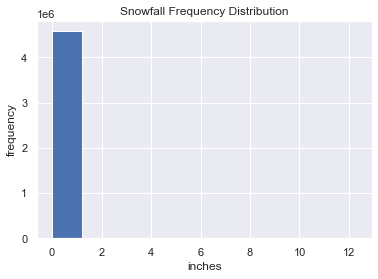

In [42]:
# Plot frequency distribution:
plt.hist(df['snowfall'])
plt.title('Snowfall Frequency Distribution')
plt.xlabel('inches')
plt.ylabel('frequency')

Once again we can see that the frequency distribution seems to be skewed to the right, meaning that the majority of rides ocurred either with no snowfall or very small quantities.

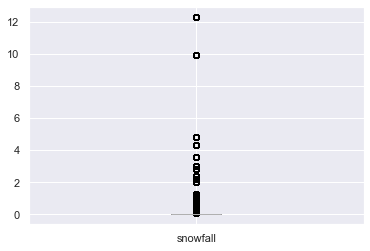

In [43]:
# Check presence of outliers:
df.boxplot(column = ['snowfall'])

There are lots of outliers, however I will discretize the variable which will facilitate the comprehension of the influence of snowfall over riding patterns:

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

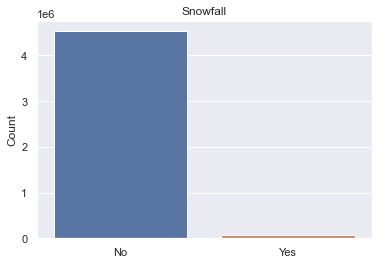

In [44]:
# Categorize the Precipitation variable:
df['snowfall'] = np.where((df.snowfall == 0.00),'No',df.snowfall)
df['snowfall'] = np.where((df.snowfall != 'No'),'Yes',df.snowfall)

# Visualize results:
sns.countplot(df['snowfall'])
plt.title('Snowfall')
plt.xlabel('')
plt.ylabel('Count')

It is possible to see that almost all the rides happened while there was no snowfall at all.

Text(-0.16499999999999915, 0.5, 'Average number of Rides')

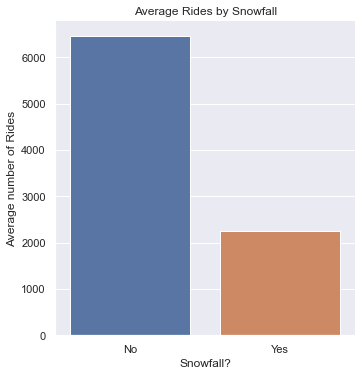

In [45]:
# Group data by Precipitation and Date to calculate the average amount of rides when there is rain or not:
mean_rides_snow = df.groupby(["snowfall", "date_text"]).size().groupby(level=0).mean().reset_index().rename(columns={0: 'avg_rides'})

# Visualize results:
sns.catplot(x = "snowfall", y = "avg_rides", kind ="bar", data = mean_rides_snow)
plt.title("Average Rides by Snowfall")
plt.xlabel("Snowfall?")
plt.ylabel("Average number of Rides")

It is possible to see that the average rider volume is far lower on days where it snowed (around 2000 rides per day), while on regular days around 6500 daily rides were registered.

### Average Temperature (°F)

In [46]:
# Descriptive statistics:
df.average_temp.describe()

count    4.596219e+06
mean     6.015842e+01
std      1.465773e+01
min      9.000000e+00
25%      5.000000e+01
50%      6.300000e+01
75%      7.200000e+01
max      9.000000e+01
Name: average_temp, dtype: float64

The average temperature while rides occurred ranges from 9 to 90 degrees Fahrenheit, with a mean value of 63°F.

Text(0, 0.5, 'frequency')

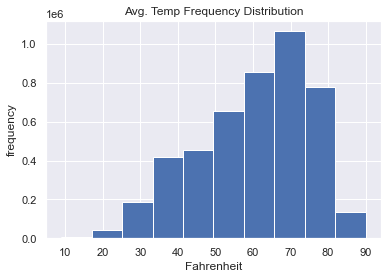

In [47]:
# Plot frequency distribution:
plt.hist(df['average_temp'])
plt.title('Avg. Temp Frequency Distribution')
plt.xlabel('Fahrenheit')
plt.ylabel('frequency') 

The distribution is skewed to the left which means that the majority of rides occurred while warmer temperatures took place.

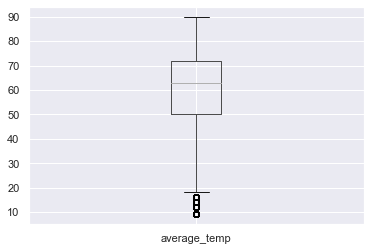

In [48]:
#Check presence of outliers:
df.boxplot(column = ['average_temp'])

There aren't lots of outliers present in the variable. The slight quantity present are related to very cold days with average temperatures of less than twenty degrees Fahrenheit. 

I will discretize the variable to make it easier to interpret:

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

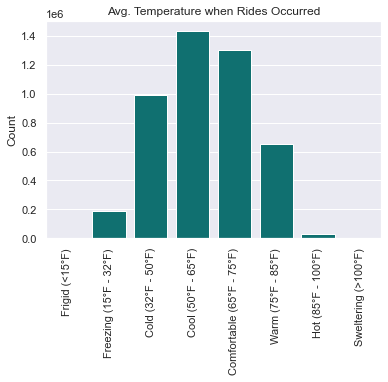

In [49]:
# Categorize the Average Temperature variable:
df.average_temp = pd.cut(df.average_temp,bins=[0,15,32,50,65,75,85,100,200],
       labels=['Frigid (<15°F)','Freezing (15°F - 32°F)','Cold (32°F - 50°F)',
               'Cool (50°F - 65°F)','Comfortable (65°F - 75°F)',
               'Warm (75°F - 85°F)','Hot (85°F - 100°F)','Sweltering (>100°F)'])

# Visualize results:
sns.countplot(df['average_temp'], color = 'teal')
plt.title('Avg. Temperature when Rides Occurred')
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Count')

We can see that the vast majority of rides occurred while average temperatures could be perceived as Cool (50 - 65°F). It is also possible to see that riders seem to favor warmer weather than cold days.

In [50]:
# I will drop the Maximum and Minimum temperature variables as this data is already represented by the average temp variable:
df.drop(columns = ['max_temp', 'min_temp'], inplace = True)

### **5.1.2 Categorical Features**

### User Type

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

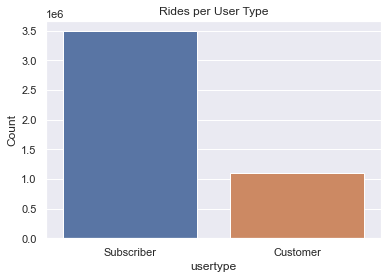

In [51]:
# Visualize proportion of rides per user type:
sns.countplot(df['usertype'])
plt.title('Rides per User Type')
plt.ylabel('Count')

It is possible to see that there is around 3 times more rides taken by Subscribers (annual or monthly subscription members) than Customers (casual users that use single trip or adventure passes).

### Year

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

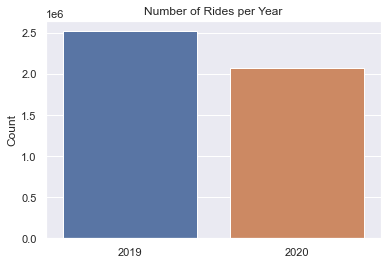

In [52]:
# Visualize proportion of rides per year:
sns.countplot(df['startyear']) #I will use 'startyear' as reference to the year in which the ride was started
plt.title('Number of Rides per Year')
plt.xlabel('')
plt.ylabel('Count')

It is possible to see that there was an overall decrease of about 500K rides from 2019 to 2020.

### Month

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

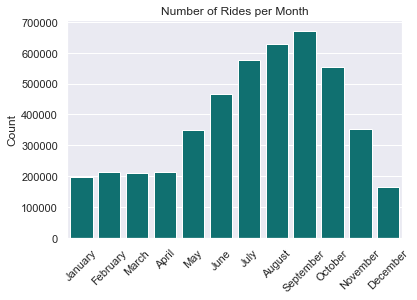

In [53]:
#Visualize amount of rides per month:
sns.countplot(df['startmonth'], order = ['January', 'February', 'March', 'April',
                                         'May', 'June', 'July', 'August', 'September',
                                         'October', 'November', 'December'],
              color = 'teal')
plt.title('Number of Rides per Month')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Count')

It is possible that there is a seasonality in the demand of bikes during the year. During the 2019 - 2020 period there was an increase of rides between the months of May and November, reaching peak demand during September.

### Day of the Month

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

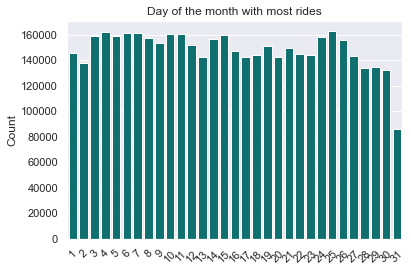

In [54]:
# Visualize amount of rides per day of the month:
sns.countplot(df['startmonthday'], color = 'teal')
plt.title('Day of the month with most rides')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Count')

There is no clear sign that shows riders favoring a certain part of the month.

### Day of the Week

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

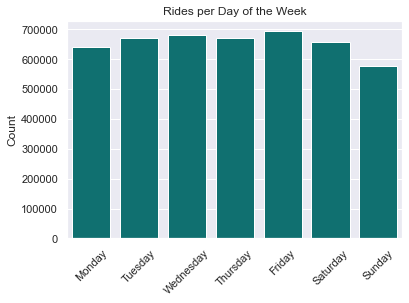

In [55]:
# Visualize amount of rides per Day of the Week:
sns.countplot(df['startday'], order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                       'Friday', 'Saturday', 'Sunday'],
              color = 'teal')
plt.title('Rides per Day of the Week')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Count')

The amount of ridses per day of the week appears to being evenly distributed. The largest amount of traffic happens on Fridays during the 2019 - 2020 period.

### Hour of the Day

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

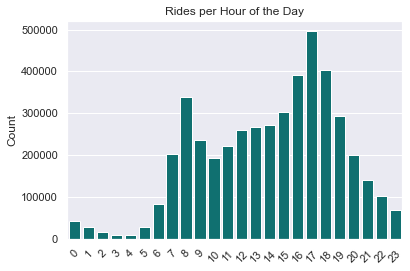

In [56]:
# Visualize amount of rides per Hour of the Day:
sns.countplot(df['start_hour'],
             color = 'teal')
plt.title('Rides per Hour of the Day')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Count')

The distribution of rides across the hour of the day during the period 2019 - 2020 is bimodal, presenting two major peaks at 8:00 am and at 5:00 pm. This behavior is probably related to the hours that people commute in and out of their workplace.

### Routes

No handles with labels found to put in legend.


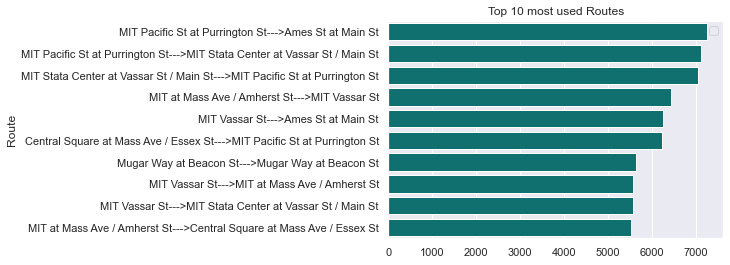

In [57]:
# Top 10 Most used routes:
sns.countplot(y = 'Route', data = df, order = df.Route.value_counts().iloc[:10].index, color = 'teal')
plt.title('Top 10 most used Routes')
plt.xlabel('')
plt.xticks(rotation = 0)
plt.legend(loc='best')

It is possible to see that the most used route during 2019 and 2020 is the one between the docks located at MIT Pacific St at Purrington St and Ames St at Main St (in that direction).

### Holiday

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

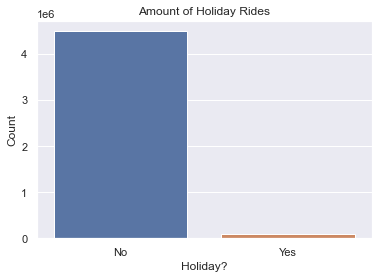

In [58]:
# Visualize amount of rides that occurred on holidays:
sns.countplot(df['Holiday'])
plt.title('Amount of Holiday Rides')
plt.xlabel('Holiday?')
plt.ylabel('Count')

It is possible to see that the vast majority of rides present on the dataset did not occur on holiday days which is obvious because of the reduced amount of days which classify as a holiday. Now, lets take a look at the average amount of riders on a holiday versus a non-holiday day.

Text(-0.16499999999999915, 0.5, 'Average number of Rides')

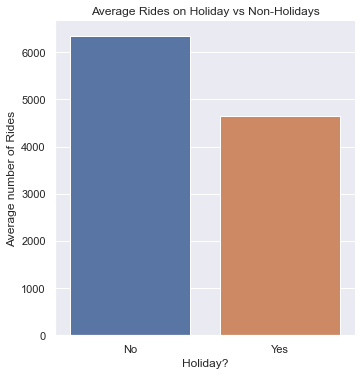

In [59]:
# Group data by Holiday and Date to calculate the average amount of rides that occurr on Holidays and Non-Holidays:
mean_rides = df.groupby(["Holiday", "date_text"]).size().groupby(level=0).mean().reset_index().rename(columns={0: 'avg_rides'})

# Visualize results:
sns.catplot(x = "Holiday", y = "avg_rides", kind ="bar", data = mean_rides)
plt.title("Average Rides on Holiday vs Non-Holidays")
plt.xlabel("Holiday?")
plt.ylabel("Average number of Rides")

Now, it is possible to see that the average amount of rides is greater in non-Holiday days than in holidays during the whole 2019 - 2020 period.

### **5.2 Bivariate Analysis**

 In this section I will focus on comparing several features over the "timeline" feature. The intention is to develop an understanding of how riding patterns have changed before and during the Covid-19 pandemic.

### Trip Duration over Timeline

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

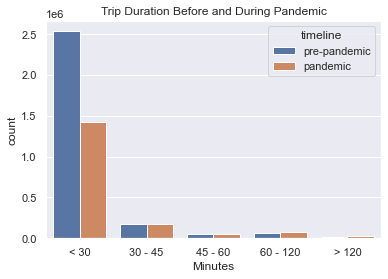

In [60]:
# Are there any differences of trip duration before and after pandemic?
sns.countplot(x = "tripduration", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Trip Duration Before and During Pandemic')
plt.xlabel('Minutes')
plt.xticks(rotation = 0)

The proportion of rides per duration appears to be comparable before and during pandemic. Less than 30 minutes rides are still the most common ride duration. However, it is as well the duration block that has taken the most dramatic ride flow decrease while other durations have sustained or even slightly increased.

### User Type over Timeline

Text(0.5, 0, '')

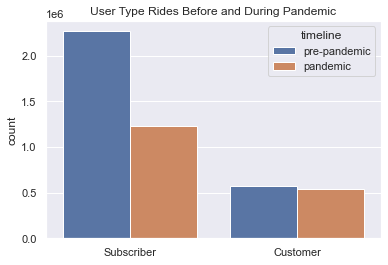

In [61]:
# User Type over timeline:
sns.countplot(x = "usertype", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('User Type Rides Before and During Pandemic')
plt.xlabel('')

Subscriber rides are the ones with the highest concentration both in pre-pandemic and during pandemic times. However, there is dramatic decrease in the amount of subscriber rides during the pandemic. On the other hand, casual customer rides have sustained through time.

# Month over Timeline

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

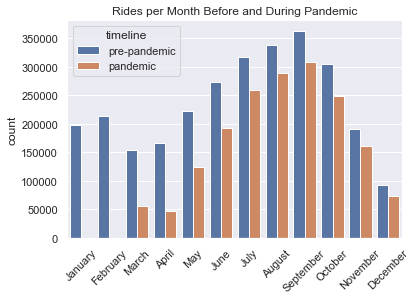

In [62]:
# Month over timeline:
sns.countplot(x = "startmonth", data = df, hue = 'timeline',
              order = ['January', 'February', 'March', 'April',
                       'May', 'June', 'July', 'August', 'September','October',
                       'November', 'December'],
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Rides per Month Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation=45)

Considering March as the month when the state of emergency in MA was declared, there was a steep decrease in the amount of monthly rides in that month. The overall amount of monthly rides is less on 2020 than on 2019 and the decrease reached its lowest point on April 2020. Then, rides slowly increased while maintaning the same proportions throughout the year.

### Month Day over Timeline

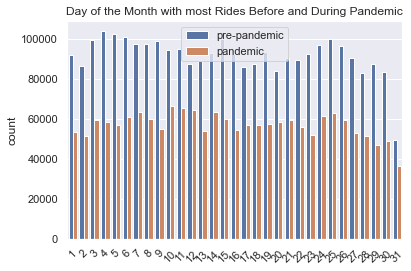

In [63]:
# Are there any month start day differences before and during pandemic?:
sns.countplot(x = "startmonthday", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Day of the Month with most Rides Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation = 45)
plt.legend(loc='best')

There are no clear patterns that suggest a specific day of the month with most rides.

### Day of the Week over Timeline

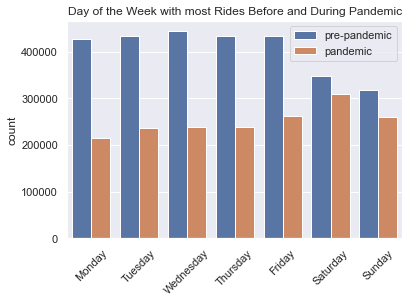

In [64]:
# Start Day over Timeline: 
sns.countplot(x = "startday", data = df, hue = 'timeline', order =
              ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                       'Friday', 'Saturday', 'Sunday'],
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Day of the Week with most Rides Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='best')

Before pandemic weekdays showed higher riding volume. During the pandemic the behavior has reverted, showing higher demand on weekends.

### Hour of the Day over Timeline

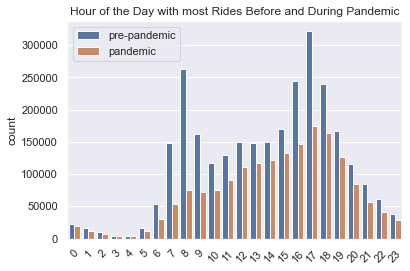

In [65]:
# How have the hourly riding trends changed before and during pandemic?:   
sns.countplot(x = "start_hour", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Hour of the Day with most Rides Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='best')

Before the pandemic the distribution of rides per hour of the day was bimodal, having the first peak at 8:00 am and the second at 5:00 pm. On the other hand, during the pandemic the distribution seems to have become unimodal, registering 5:00 pm as the hour with more riding demand.

### Routes over Timeline

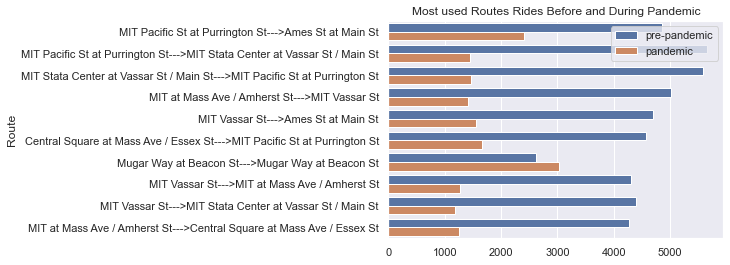

In [66]:
# Top 10 Most used routes before and during the pandemic:
sns.countplot(y = "Route", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'],
              order = df.Route.value_counts().iloc[:10].index)
plt.title('Most used Routes Rides Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation = 0)
plt.legend(loc='best')

Before the pandemic most riders picked the bikes at the MIT Station St at Purrington St dock, and dropped at Main St dock. On the other hand, during the pandemic most riders picked and dropped bikes at the Mugar Way at Beacon St dock.

### Holiday over Timeline

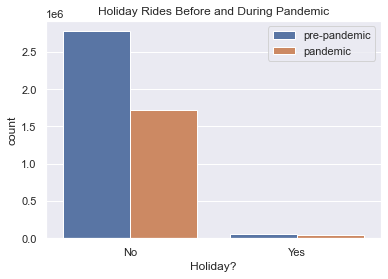

In [67]:
# Are there any differences in holiday rides before and after pandemic:  
sns.countplot(x = "Holiday", data = df, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Holiday Rides Before and During Pandemic')
plt.xlabel('Holiday?')
plt.xticks(rotation=0)
plt.legend(loc='best')

The proportion of holiday and non-holiday rides before and during the pandemic are comparable. There is the expected decrease in the overall amount of rides.

Text(-0.16499999999999915, 0.5, 'Average number of Rides')

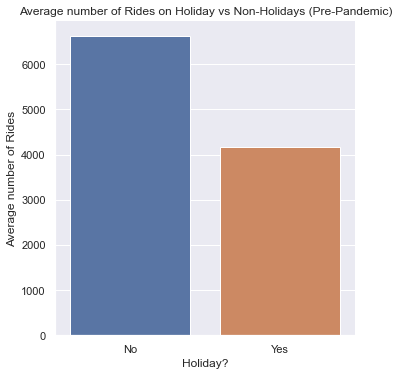

In [68]:
# Group data by Holiday and Date to calculate the average amount of rides that occurr on Holidays and Non-Holidays:
pre_pandemic_rides = df[df['timeline'] == 'pre-pandemic']

mean_rides_pre = pre_pandemic_rides.groupby(["Holiday", "date_text"]).size().groupby(level=0).mean().reset_index().rename(columns={0: 'avg_rides'})

# Visualize results:
sns.catplot(x = "Holiday", y = "avg_rides", kind ="bar", data = mean_rides_pre)
plt.title("Average number of Rides on Holiday vs Non-Holidays (Pre-Pandemic)")
plt.xlabel("Holiday?")
plt.ylabel("Average number of Rides")

Before the pandemic, non-holiday days regitered on average around 6500 rides per day, while on holiday days there were around 4000 average rides per day.

Text(-0.16499999999999915, 0.5, 'Average number of Rides')

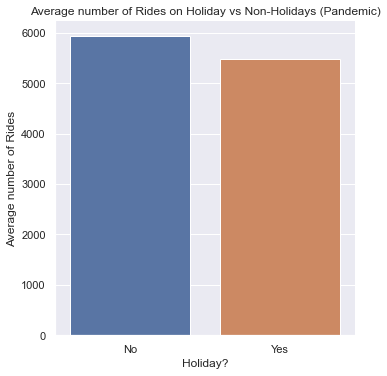

In [69]:
# Group data by Holiday and Date to calculate the average amount of rides that occurr on Holidays and Non-Holidays:
pandemic_rides = df[df['timeline'] == 'pandemic']

mean_rides_pan = pandemic_rides.groupby(["Holiday", "date_text"]).size().groupby(level=0).mean().reset_index().rename(columns={0: 'avg_rides'})

# Visualize results:
sns.catplot(x = "Holiday", y = "avg_rides", kind ="bar", data = mean_rides_pan)
plt.title("Average number of Rides on Holiday vs Non-Holidays (Pandemic)")
plt.xlabel("Holiday?")
plt.ylabel("Average number of Rides")

On the other hand, during the pandemic it is possible to see that non-Holiday days the gap between both kinds of days is much smaller showing an average of 6000 daily rides on non-Holidays and around 5500 average rides on Holidays.

### Holiday Name over Timeline

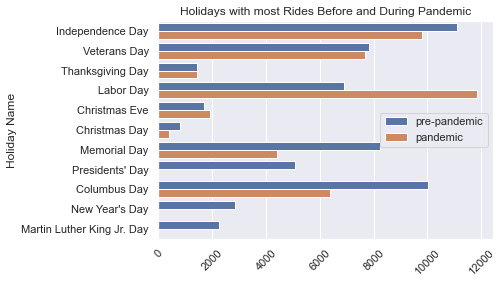

In [70]:
# Which were the holidays with most rides before and during pandemic?
cond = df[df['Holiday Name'] != 'None']

sns.countplot(y = "Holiday Name", data = cond, hue = 'timeline',
              hue_order = ['pre-pandemic', 'pandemic'])
plt.title('Holidays with most Rides Before and During Pandemic')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='best')

Before the pandemic started Independence Day was the holiday with most rides. On the other hand, during the pandemic Labor Day has become the top riding holiday surpasing by almost 4000 rides previous year results.

## **6. Conclusions**

After contemplating the results obtained during the exploration and visualization phase of the project, the following answers were found:

### 6.1 Most used routes:

Due to the large number of possible routes, I will focus on the top 10 most frequent dock to dock paths. In first place, overall, on the 2019 – 2020 period the ten most used routes were:

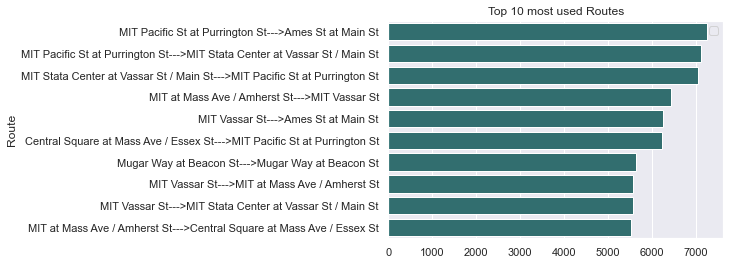

It is possible to see that the busiest route between docking stations is the one from MIT Pacific St at Purrington St to Ames St at Main St. These are located as follows:

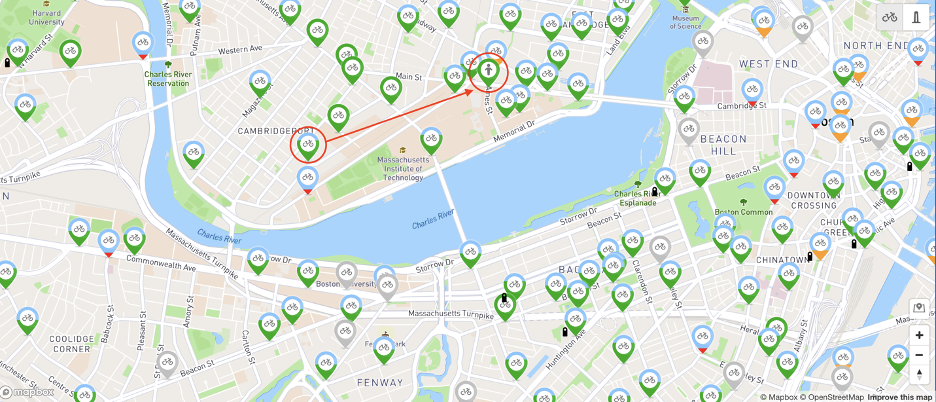

### 6.2 How do Holidays influence bike sharing?

Before the pandemic, non-holidays registered an average of 6500 rides per day, while on holidays there were 4000 average rides per day approximately.

On the other hand, during the pandemic non-holiday days still registered a greater number of average rides per day. However, it is possible to see that the gap between both kinds of days is much smaller showing an average of 6000 daily rides on non-holidays and around 5500 average rides per day on holidays.

### 6.3 How does weather influence bike sharing?

In terms of how weather conditions influence bike sharing, it is possible to see the following trends:

* Precipitation: there are on average 5300 rides on rainy days, while non-rainy days registered on average 7000 rides.
* Snowfall: there is less riding volume on days with snowfall, at around 2000 average rides. Days with no snowfall registered 6500 rides on average.

### 6.4 How has the pandemic changed bike sharing patterns?

The pandemic has changed bike-sharing patterns across Boston in the following ways:

* **Trip Duration**:

The Blue Bikes service is mainly used in the city of Boston and surrounding metro areas for short trips. Both before and during the pandemic, the majority of rides registered are of a duration of 20 minutes or less, which suggests that bikes are used for what is called “Last Mile Transportation” (last stretch of a trip).
Now, there was a big decrease in the “less than 30 minutes” ride segment during the pandemic which is probably due to the work-from-home measures implemented (less riders commuting to work or college). However, despite that decrease the frequency of other trip duration riding segments actually sustained or even increased during the pandemic. One hypothesis to explain this behavior is that even though users were not riding bikes for day-to-day commuting, they may have increased their use for recreational purposes.

* **User Type**:

Before and during the pandemic the highest frequency user type are Subscribers, which are the kind of users that buy either monthly or annual memberships due to the expected high use rate. 
On year 2020 (during the pandemic) there was a large decrease in the number of rides performed by Subscribers, however the Casual user segment did not register a large difference with respect to 2019. This again, suggests that riders were not commuting as much but they did use the service for recreational purposes.

* **Month**:

After visualizing the number of rides made per month it is possible to conclude that the time of the year with most bike demand is between July and October in both pre-pandemic and pandemic timeframes. The pandemic did not affect the seasonality of the rides; however, it did decrease the overall number of monthly trips.

* **Day of the Week**:

Before the pandemic there was greater rider traffic during weekdays. On the other hand, during the pandemic the behavior has completely reversed. This again shows the increased recreational use of the bikes, and how work-from-home measures have drastically modified customer behavior.

* **Hour of the Day**:

Before the pandemic the distribution of rides per hour of the day was bimodal, having the first peak at 8:00 am and the second at 5:00 pm. Both of these riding hours coincide with the times when people are going to and coming from work. On the other hand, during the pandemic the distribution seems to have become unimodal, registering 5:00 pm as the hour with more riding demand. This reflects on the fact that users are not leaving for work almost the entire day, and then at the end of the day the volume picks up.

* **Routes**:

As mentioned before, pre-pandemic the most popular route was the one from MIT Pacific St at Purrington St to Ames St at Main St (in red). On the other hand, during the pandemic the most popular start and end point is at the Mugar Way & Beacon St dock (in black).

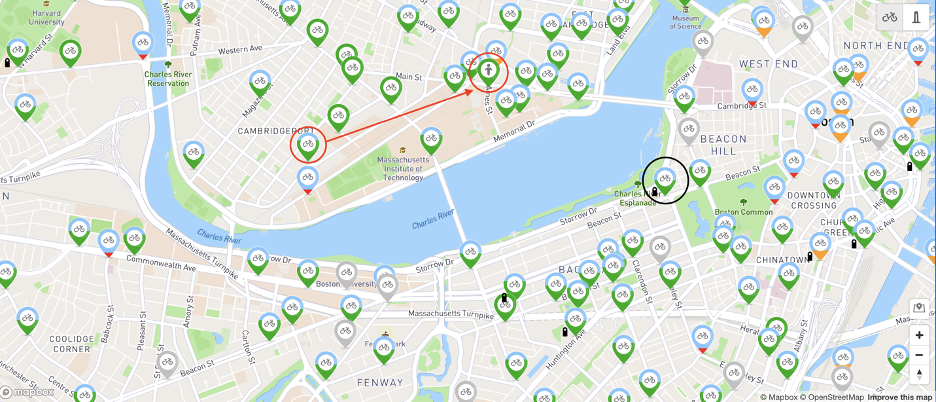

In my own experience, as a resident of Boston I have witnessed a high volume of recreational rides that start or end at the Mugar Way & Beacon St dock (black) since it is conveniently located to connect with some of the city’s most notable sight-seeing places such as the Charles River Esplanade, the Public Garden, the Boston Common, Back Bay, etc.

Thanks for reading!

If you want to know more about my work visit me at:

[(LinkedIn)](https://www.linkedin.com/in/juanleston/) | [(Github)](https://github.com/juanleston)